## Notebook to visualize the performance of AA autoencoders for 2D linear advection

In [1]:
## Load modules
%matplotlib inline

import numpy as np
import scipy
from scipy.interpolate import RBFInterpolator, interp2d
import os
import gc
import argparse
import time
import importlib
from importlib import reload as reload
from pathlib import Path
import sys


from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler

import tensorflow as tf
print("Tensorflow v"+str(tf.__version__))
if tf.__version__ == '1.15.0':
    tf.compat.v1.enable_eager_execution()
elif tf.__version__.split('.')[0] == 2: # in ['2.2.0','2.3.0']:
    print("Setting Keras backend datatype")
    tf.keras.backend.set_floatx('float32')
    tf.debugging.set_log_device_placement(True)

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, LSTM, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
# tf.keras.backend.set_floatx('float64')


np.random.seed(0)

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, ScalarFormatter, FormatStrFormatter

from matplotlib import animation
matplotlib.rc('animation', html='html5')
from IPython.display import display
import matplotlib.ticker as ticker
from matplotlib import rcParams
from matplotlib.offsetbox import AnchoredText


# Plot parameters
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 20,
                     'lines.linewidth': 2,
                     'lines.markersize':10,
                     'axes.labelsize': 16, 
                     'axes.titlesize': 20,
                     'xtick.labelsize': 16,
                     'ytick.labelsize': 16,
                     'legend.fontsize': 16,
                     'axes.linewidth': 2})

import itertools
colors = itertools.cycle(['r','g','b','m','y','c'])
markers = itertools.cycle(['p','d','o','^','s','x',]) #'D','H','v','*'])

try:
    base_dir.exists()
except:
    curr_dir = Path().resolve()
    base_dir = curr_dir.parent
data_dir = base_dir / "data" / "adv2d"
fig_dir = base_dir / "figures"
utils_dir = base_dir / "src" / "utils"
nn_dir = base_dir / "src" / "nn_model"
work_dir = base_dir / "examples"
model_dir = base_dir / "data" / "saved_models" / "ae_param_models"

sys.path.append(str(utils_dir.absolute()))
sys.path.append(str(nn_dir.absolute()))

import data_utils as du
import tf_utils as tu
import plot_utils as pu
import aa_autoencoder as aa




Tensorflow v2.5.0


In [2]:

param_list = [5, 8, 10, 16, 20, 24]; flag = 'sigma';  # pulse size as a parameter
param_train = [5, 10, 16]; param_test = [8, 20]

model ='Pulse'

soln_names = ['pulse']; comp_names = {0:'pulse'}; Nc = 1 

def set_symbol(flag):
    if flag == 'speed':
        return 'c'
    elif flag == 'sigma':
        return '$\sigma$'

In [3]:
load_ae_model_1 = True

if load_ae_model_1:
    pre_trained_dir = model_dir / "saved_model_AA1"
    mnum1 = str(pre_trained_dir).split('saved_model_')[1]


    ## When using custom loss functions while training, there are two ways
    ## to load a saved model
    ## 1) If loaded model will not be used for retraining, then
    ##   use 'compile=False' option while loading so that TF does
    ##   search for loss functions
    u_autoencoder1 = tf.keras.models.load_model(pre_trained_dir / "u_autoenc", compile=False)
    histdir1 = 'model_history_%d.npz'%mnum1
    ae_training = np.load(pre_trained_dir / histdir1)

    print(ae_training['msg'])

    loss_ae1 = ae_training['loss']
    vloss_ae1 = ae_training['valloss'] 
    sloss_ae1 = ae_training['shiftloss'] 
    rloss_ae1 = ae_training['reconloss'] 
    lr_ae1 = ae_training['lr']
    epochs_ae1 = ae_training['epochs']
    u_max = ae_training['umax']
    u_min = ae_training['umin']
    augment_output1 = ae_training['augment']
    
    u_autoencoder1.summary()

Sigma = [5,10,16], speed = [1], train_end = 1.0*T,
Trains both shift and true decoder, Time = 4h 27m 46s,
Step decay LR scheduler starting from 1.00e-04, Batch Size = 32,
Decaying 15% every 456 epochs. Trained for 8000 epochs,
For epochs <=2500: Loss = 0.00*Shift + 0.98*True,
For epochs > 2500: Loss = 0.10*Shift + 0.88*True,
90% NMSE + 10% Huber, L2 regularization, Scaling to [0,1],
Only Encoder input is augmented by parameter value
Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  63516886  
_________________________________________________________________
shift (Shift)                multiple                  63616943  
_________________________________________________________________
decoder (Decoder)            multiple                  63616943  
Total params: 190,750,772
Trainable params: 190,750,772
Non-trainable params: 0


In [4]:
load_ae_model_2 = True

if load_ae_model_2:
    pre_trained_dir = model_dir / "saved_model_AA2"
    mnum2 = str(pre_trained_dir).split('saved_model_')[1]

    ## When using custom loss functions while training, there are two ways
    ## to load a saved model
    ## 1) If loaded model will not be used for retraining, then
    ##   use 'compile=False' option while loading so that TF does
    ##   search for loss functions
    u_autoencoder2 = tf.keras.models.load_model(pre_trained_dir / "u_autoenc",compile=False)
    histdir2 = 'model_history_%d.npz'%mnum2
    ae_training = np.load(pre_trained_dir / histdir2)

    print(ae_training['msg'])

    loss_ae2 = ae_training['loss']
    vloss_ae2 = ae_training['valloss'] 
    sloss_ae2 = ae_training['shiftloss'] 
    rloss_ae2 = ae_training['reconloss'] 
    lr_ae2 = ae_training['lr']
    epochs_ae2 = ae_training['epochs']
    u_max2 = ae_training['umax']; assert u_max2 == u_max
    u_min2 = ae_training['umin']; assert u_min2 == u_min
    augment_output2 = ae_training['augment']
    
    u_autoencoder2.summary()

Sigma = [5,10,16], speed = [1], train_end = 1.0*T,
Trains both shift and true decoder, Time = 4h 38m 20s,
Step decay LR scheduler starting from 1.00e-04, Batch Size = 24,
Decaying 15% every 456 epochs. Trained for 8000 epochs,
For epochs <=2500: Loss = 0.00*Shift + 0.98*True,
For epochs > 2500: Loss = 0.10*Shift + 0.88*True,
90% NMSE + 10% Huber, L2 regularization, Scaling to [0,1],
Both Encoder input and Decoder output are augmented by parameter value
Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  63516886  
_________________________________________________________________
shift (Shift)                multiple                  63617573  
_________________________________________________________________
decoder (Decoder)            multiple                  63617573  
Total params: 190,752,032
Trainable params: 190,752,032
Non-

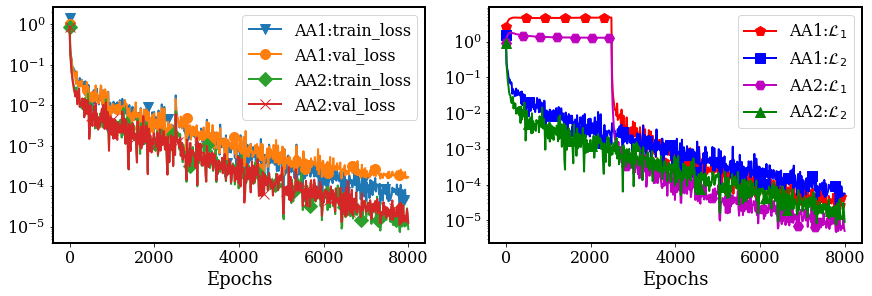

In [5]:
## Visualization losses and learning rate evolution
if load_ae_model_1 and load_ae_model_2:
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4),constrained_layout=True)

    num_epochs_u = np.arange(epochs_ae1)
    idx_end = epochs_ae1
    ax[0].semilogy(num_epochs_u[:idx_end:15],loss_ae1[:idx_end:15],label='%s:train_loss'%mnum1,
                   marker='v',markevery=31)
    ax[0].semilogy(num_epochs_u[:idx_end:15],vloss_ae1[:idx_end:15],label='%s:val_loss'%mnum1,
                   marker='o',markevery=37)
    ax[0].semilogy(num_epochs_u[:idx_end:15],loss_ae2[:idx_end:15],label='%s:train_loss'%mnum2,
                   marker='D',markevery=27)
    ax[0].semilogy(num_epochs_u[:idx_end:15],vloss_ae2[:idx_end:15],label='%s:val_loss'%mnum2,
                   marker='x',markevery=34)
    ax[0].legend()

    ax[1].semilogy(num_epochs_u[:idx_end:15],sloss_ae1[:idx_end:15],label='%s:$\mathcal{L}_1$'%mnum1,
                   color='r', marker='p',markevery=31)
    ax[1].semilogy(num_epochs_u[:idx_end:15],rloss_ae1[:idx_end:15],label='%s:$\mathcal{L}_2$'%mnum1,
                   color='b', marker='s',markevery=37)
    ax[1].semilogy(num_epochs_u[:idx_end:15],sloss_ae2[:idx_end:15],label='%s:$\mathcal{L}_1$'%mnum2,
                   color='m', marker='H',markevery=27)
    ax[1].semilogy(num_epochs_u[:idx_end:15],rloss_ae2[:idx_end:15],label='%s:$\mathcal{L}_2$'%mnum2,
                   color='g', marker='^',markevery=34)
    ax[1].legend(ncol=1)

    for i in range(2):       
        ax[i].set_xlabel('Epochs',fontsize=18)

#     plt.savefig(fig_dir+'CombPulse_par%s_AEtrainingComparison_epochs%d.png'%(flag,epochs_ae1),dpi=300,bbox_inches='tight')



In [7]:
## Load snapshot data

snap_data = {}; times_offline = {}
c = {}; sigma = {}
snap_start = {}; snap_end = {}
for indx,val in enumerate(param_train):
    
    datafile = 'Gaussian2d_pulse_500x200_c1.00_sigma'+'%.4f'%val+'.npz'
    data = np.load(os.path.join(data_dir, datafile))
    
    c[indx] = float(datafile.split('_c')[1].split('_')[0])
    sigma[indx] = float(datafile.split('_sigma')[1].split('.npz')[0])
    print("\nLoading snapshots for c = %f, sigma = %f"%(c[indx], sigma[indx]))
    
    snap_data[indx], times_offline[indx], nodes, Nx, Ny, snap_start[indx], snap_end[indx] = du.read_data(data, soln_names)
        


Loading snapshots for c = 1.000000, sigma = 5.000000
Loaded 420 snapshots of dimension 100701 for ['pulse']  spanning times [0.000, 6.983] mins

Loading snapshots for c = 1.000000, sigma = 10.000000
Loaded 420 snapshots of dimension 100701 for ['pulse']  spanning times [0.000, 6.983] mins

Loading snapshots for c = 1.000000, sigma = 16.000000
Loaded 420 snapshots of dimension 100701 for ['pulse']  spanning times [0.000, 6.983] mins


In [8]:
## Prepare training snapshots

Nn = Nx * Ny

## number of steps to skip in selecting training snapshots for SVD basis
snap_incr=2
Nt = {}
Nt_train = {}
train_end = {}
for indx,val in enumerate(param_train):
    Nt[indx] = times_offline[indx].size
    train_end[indx] = int(Nt[indx]*1.00)
    Nt_train[indx] = times_offline[indx][:train_end[indx]+1:snap_incr].size
    print('{5}: Using {0} training snapshots for {1} = {2:.2f} in time interval [{3:.2f},{4:.2f}] mins'.format(
                            Nt_train[indx], flag, param_train[indx], times_offline[indx][:train_end[indx]+1:snap_incr][0]/60, 
                            times_offline[indx][:train_end[indx]+1:snap_incr][-1]/60, indx))

del data
gc.collect()

0: Using 210 training snapshots for sigma = 5.00 in time interval [0.00,6.97] mins
1: Using 210 training snapshots for sigma = 10.00 in time interval [0.00,6.97] mins
2: Using 210 training snapshots for sigma = 16.00 in time interval [0.00,6.97] mins


23386

In [9]:
def set_label(key):
    if key == 'pulse':
        ky = 'u'
    
    return ky

In [10]:
## Load shifted snapshots   
print("Loading pre-computed shifted snapshots -----\n")

shifted_snap = {}
for indx,val in enumerate(param_train):
    
    datafile = 'Shift_Gaussian2d_pulse_500x200_c1.00_sigma'+'%.4f'%val+'.npz'
    shift_data = np.load(os.path.join(data_dir, datafile))

    shifted_snap[indx] = {}
    for key in soln_names:
        tmp = shift_data[key].reshape((Nn,-1))
        shifted_snap[indx][key] = np.outer(tmp,np.ones(Nt[indx]))


del shift_data
gc.collect()

Loading pre-computed shifted snapshots -----



64

In [11]:
###  ***** Prepare Autoencoder input data *******
## 1. Concatenate parametric snapshots to prepare
##    input features for AA Autoencoder training

u = np.empty((0,Nn),)
u_shift = np.empty((0,Nn),)

for indx,val in enumerate(param_train):
    u_snap = snap_data[indx]['pulse'][:,:train_end[indx]+1:snap_incr].T    
    u = np.vstack((u,u_snap))
    u_shift_snap = shifted_snap[indx]['pulse'][:,:train_end[indx]+1:snap_incr].T
    u_shift = np.vstack((u_shift,u_shift_snap))
    

validation_data = True

skip_start = snap_incr//2
if validation_data:
    u_val = np.empty((0,Nn),)
    u_val_shift = np.empty((0,Nn),)
    for indx,val in enumerate(param_train):
        u_val_snap = snap_data[indx]['pulse'][:,skip_start:train_end[indx]+1:snap_incr].T
        u_val_shift_snap = shifted_snap[indx]['pulse'][:,skip_start:train_end[indx]+1:snap_incr].T
        u_val = np.vstack((u_val, u_val_snap))
        u_val_shift = np.vstack((u_val_shift, u_val_shift_snap))
    

In [12]:
## Scale Input Features to lie between [0,1]

scaling=True

if scaling:
    u, u_shift, _, _ = du.data_scaler(u, u_shift, u_max, u_min)

    if validation_data:
        u_val, u_val_shift, _, _ = du.data_scaler(u_val, u_val_shift, u_max, u_min)
        
else:
    pass



In [13]:
###  ***** Prepare Autoencoder input data *******
## 2. Augment input feature states with scaled 
##    parameter values

u_sigma = np.empty((0,1),)
u_shift_sigma = np.empty((0,1),)

p_max = np.asarray(param_list).max()
for indx,val in enumerate(param_train/p_max):
    u_sigma = np.vstack((u_sigma,val*np.ones((Nt_train[indx],1))))
    u_shift_sigma = np.vstack((u_shift_sigma,val*np.ones((Nt_train[indx],1)) ))
    
u = np.hstack(( u,u_sigma))
u_shift = np.hstack(( u_shift, u_shift_sigma))


if validation_data:
    u_val_sigma = np.empty((0,1),)
    u_val_shift_sigma = np.empty((0,1),)
    for indx,val in enumerate(param_train/p_max):
        val_steps = np.minimum(times_offline[indx][skip_start:train_end[indx]+1:snap_incr].size, Nt_train[indx])
        u_val_sigma = np.vstack((u_val_sigma, val*np.ones((val_steps,1)) ))
        u_val_shift_sigma = np.vstack((u_val_shift_sigma, val*np.ones((val_steps,1)) ))
        
        
    u_val = np.hstack(( u_val, u_val_sigma))
    u_val_shift = np.hstack(( u_val_shift, u_val_shift_sigma))



In [14]:
### Predict using data points not in training set

pred_shift = {}; pred_recon = {}
for iparam,val in enumerate(param_train):
    iparam = param_train.index(val); 
    print("Testing AE predictions for %s = %.2f (parameter number = %d)"%(flag, val, iparam))

    u_test = snap_data[iparam]['pulse'][:,:snap_end[iparam]+1].T
    u_shift_test = shifted_snap[iparam]['pulse'][:,:snap_end[iparam]+1].T
    if scaling:
        u_test, u_shift_test, _, _ = du.data_scaler(u_test, u_shift_test, u_max, u_min)
        
    u_test = np.hstack(( u_test, val/p_max*np.ones((Nt[iparam],1)) ))
    u_shift_test = np.hstack(( u_shift_test, val/p_max*np.ones((Nt[iparam],1)) ))


    u_autoencoder = u_autoencoder1; augment_out = augment_output1; mnum = mnum1
        
    encoded_u_test = u_autoencoder.encoder(u_test).numpy()
    decoded_u_test = u_autoencoder.shift(encoded_u_test).numpy()
    recon_u_test = u_autoencoder.decoder(encoded_u_test).numpy()

    pred_shift[iparam] = {}
    pred_recon[iparam] = {}
    if augment_out:
        pred_recon[iparam]['pulse'] = du.scaler_inverse(recon_u_test[:,:-1], u_max, u_min, scaling=scaling).T
        pred_shift[iparam]['pulse'] = du.scaler_inverse(decoded_u_test[:,:-1], u_max, u_min, scaling=scaling).T
    else:
        pred_recon[iparam]['pulse'] = du.scaler_inverse(recon_u_test[:,:], u_max, u_min, scaling=scaling).T
        pred_shift[iparam]['pulse'] = du.scaler_inverse(decoded_u_test[:,:], u_max, u_min, scaling=scaling).T



Testing AE predictions for sigma = 5.00 (parameter number = 0)
Testing AE predictions for sigma = 10.00 (parameter number = 1)
Testing AE predictions for sigma = 16.00 (parameter number = 2)


In [15]:
def compare_soln(uh,utrue,iplot,times_pred,times_true,Nx,Ny,key='pulse'):
    
    tn_index = np.searchsorted(times_pred,times_true[iplot])
    urom = uh[key][:,tn_index].reshape((Ny,Nx))
    uplot = utrue[key][:,iplot].reshape((Ny,Nx))
    err = urom-uplot
   
   
    ax1 = plt.subplot(1,3,1); ax1.axis('off')
    surf1 = ax1.imshow(urom, extent=[-100,100,0,500], origin="lower")
    ax1.set_title("AE Pulse\n $%1.3f<\mathbf{%s}<%1.3f$"%(np.amin(urom),set_label(key),
                                                                 np.amax(urom)),fontsize=20)


    ax2 = plt.subplot(1,3,2); ax2.axis('off')
    surf2 = ax2.imshow(uplot, extent=[-100,100,0,500], origin="lower")
    ax2.set_title("True Pulse\n $%1.3f<\mathbf{%s}<%1.3f$"%(np.amin(uplot),set_label(key),
                                                                 np.amax(uplot)),fontsize=20)

    cbar1 = plt.colorbar(surf1, ax=[ax1, ax2], shrink=0.8, aspect=40, pad = 0.03, location='right')
    cbar1.ax.tick_params(labelsize=20)
    
    ax3 = plt.subplot(1,3,3); ax3.axis('off')
    surf3 = ax3.imshow(err, extent=[-100,100,0,500], origin="lower")
    ax3.set_title("$%1.5f$< error$<%1.5f$\n Rel. Err. = $%1.5f$ "%(np.amin(err),
                                                    np.amax(err),
                                                    np.linalg.norm(err)/np.linalg.norm(uplot)),
                                                    fontsize=20)
    
    cbar2 = plt.colorbar(surf3, shrink=0.8,aspect=40, pad = 0.03)
    cbar2.ax.tick_params(labelsize=20)
    

comparing AE reconstruction at t = 6.92 mins


Text(0.5, 0.98, 'Comparing AE predictions of shifted snapshots \nfor sigma = 5.00 at t = 6.92 mins')

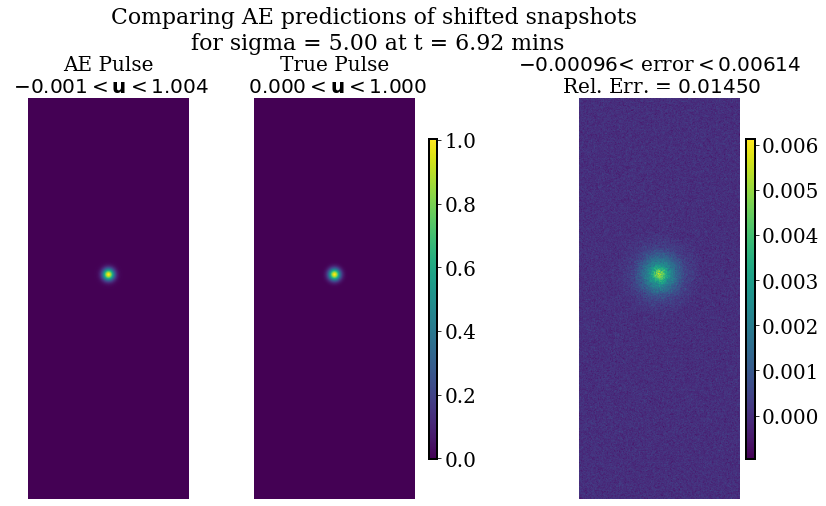

In [16]:
### Visualizing reconstruction of shifted snapshots using shift decoder

fig = plt.figure(figsize=(14,8))
ky = 'pulse'; 
np.random.seed(2021)
iparam = 0 
iplot = times_offline[iparam].size-5
print("comparing AE reconstruction at t = {0:.2f} mins".format(times_offline[iparam][iplot]/60))
fig.tight_layout()
fig.subplots_adjust(top=0.82)
compare_soln(pred_shift[iparam],shifted_snap[iparam],iplot,times_offline[iparam],times_offline[iparam],Nx,Ny,ky)
fig.suptitle("Comparing AE predictions of shifted snapshots \nfor %s = %.2f at t = %.2f mins"%(flag, param_train[iparam], times_offline[iparam][iplot]/60),fontsize=22, y=0.98)

# plt.savefig(fig_dir+'%s%s_c%.1f_sigma%.2f_SegmentedShiftAEshift_t%.3f_swish_NMSE.png'%(model,mnum,c[iparam],sigma[iparam],times_offline[iparam][iplot]/60),dpi=300,bbox_inches='tight')



comparing AE reconstruction at t = 6.92 mins


Text(0.5, 0.98, 'Comparing AE predictions of true snapshots \nfor sigma = 5.00 at t = 6.92 mins')

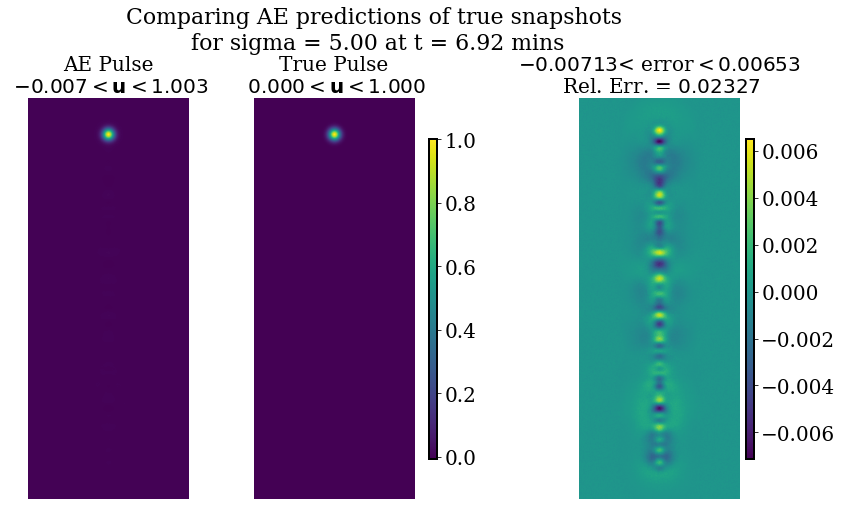

In [17]:
### Visualizing direct reconstruction using  true decoder

fig = plt.figure(figsize=(14,8))

print("comparing AE reconstruction at t = {0:.2f} mins".format(times_offline[iparam][iplot]/60))
fig.tight_layout()
fig.subplots_adjust(top=0.82)
compare_soln(pred_recon[iparam],snap_data[iparam],iplot,times_offline[iparam],times_offline[iparam],Nx,Ny,ky)
fig.suptitle("Comparing AE predictions of true snapshots \nfor %s = %.2f at t = %.2f mins"%(flag, param_train[iparam], times_offline[iparam][iplot]/60),fontsize=22, y=0.98)


# plt.savefig(fig_dir+'%s%s_c%.1f_sigma%.2f_SegmentedShiftAErecon_t%.3f_swish_NMSE.png'%(model,mnum,c[iparam],sigma[iparam],times_offline[iparam][iplot]/60),dpi=300,bbox_inches='tight')



In [18]:
## Compute rel error for decoded prediction of shifted solutions
rel_err_shift = {}
rel_err_recon = {}
key = 'pulse'
shift_max = np.zeros(len(param_train))
recon_max = np.zeros(len(param_train))
for iparam,val in enumerate(param_train[:4]):
    iparam = param_train.index(val);
    true = shifted_snap[iparam][key][:,:snap_end[iparam]+1]
    true2 = snap_data[iparam][key][:,:snap_end[iparam]+1]
    rel_err_shift[iparam] = np.linalg.norm(pred_shift[iparam][key]-true,axis=0)/np.linalg.norm(true,axis=0)
    rel_err_recon[iparam] = np.linalg.norm(pred_recon[iparam][key]-true2,axis=0)/np.linalg.norm(true2,axis=0)
    shift_max[iparam] = np.amax(rel_err_shift[iparam][:-1])
    recon_max[iparam] = np.amax(rel_err_recon[iparam][:-1])


Text(0.5, 0, 'Time, $t$ (mins)')

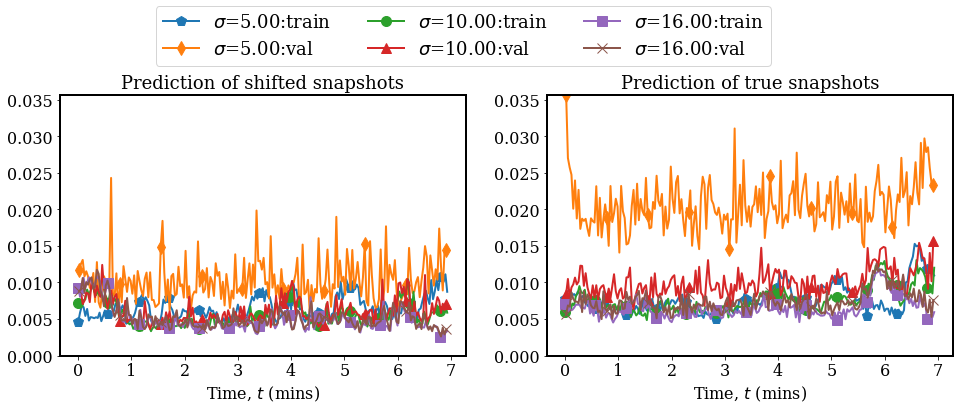

In [19]:
### Visualize relative errors for both decoders

fig = plt.figure(figsize=(16,5))
fig.tight_layout()
fig.subplots_adjust(top=0.85)


markers = itertools.cycle(['p','d','o','^','s','x',]) #'D','H','v','*'])
    
if validation_data:
    val_skip = 2
else:
    val_skip = 1
    
y_max = np.maximum(shift_max.max(), recon_max.max())

ax1 = plt.subplot(1,2,1); 
for iparam,val in enumerate(param_train[:4]):
    iparam = param_train.index(val);

    indx = times_offline[iparam][:snap_end[iparam]+1]/60
    val_mark = int(indx.size*1.0)-3
    ax1.plot(indx[:val_mark:val_skip],rel_err_shift[iparam][:val_mark:val_skip],
            label='%s=%.2f:train'%(set_symbol(flag),val), 
             marker=next(markers),markevery=17,markersize=10,)
    if validation_data:
        ax1.plot(indx[1:val_mark:val_skip],rel_err_shift[iparam][1:val_mark:val_skip],
                label='%s=%.2f:val'%(set_symbol(flag),val), 
                 marker=next(markers),markevery=23,markersize=10,)
ax1.set_title('Prediction of shifted snapshots',fontsize=18)
ax1.set_ylim(top=y_max, bottom = 0)


ax2 = plt.subplot(1,2,2); 
for iparam,val in enumerate(param_train[:4]):
    iparam = param_train.index(val);

    indx = times_offline[iparam][:snap_end[iparam]+1]/60
    val_mark = int(indx.size*1.0)-3  
    ax2.plot(indx[:val_mark:val_skip],rel_err_recon[iparam][:val_mark:val_skip], 
                marker=next(markers), markevery=17,markersize=10,)
    if validation_data:
        ax2.plot(indx[1:val_mark:val_skip],rel_err_recon[iparam][1:val_mark:val_skip],
                    marker=next(markers), markevery=23,markersize=10,)
ax2.set_title('Prediction of true snapshots',fontsize=18)
ax2.set_ylim(top=y_max, bottom = 0)


lg = fig.legend(ncol=len(param_train),bbox_to_anchor=(0.75, 1.12),fontsize=18)
ax1.set_xlabel('Time, $t$ (mins)'); ax2.set_xlabel('Time, $t$ (mins)')
    

# plt.savefig(fig_dir+'%s%s_par%s_TrainSegmentedShiftAErel_err_swish_NMSE.png'%(model,mnum,flag),dpi=300,bbox_extra_artists=(lg,),bbox_inches='tight')


In [20]:
## Evaluate predictions on a dataset with unseen parameter value

new_test = True

if new_test:
    c_new = {}; sigma_new = {}; snap_new = {}; times_new = {};
    snap_start_new, snap_end_new, Nt_new = {}, {}, {}
    shifted_snap_new = {}
            
    test_param = [8, 20]
    for inx,val in enumerate(test_param):
        c_new[inx] = 1; sigma_new[inx] = val
        new_data = np.load(os.path.join(data_dir,'Gaussian2d_pulse_500x200_c1.00_sigma%.4f.npz'%sigma_new[inx]))
        print("\nChosen parameter: %s = %f"%(flag, test_param[inx]))
        print("Loading pre-computed true snapshots -----")

        snap_new[inx], times_new[inx], nodes2, Nx2, Ny2, snap_start_new[inx], snap_end_new[inx] = du.read_data(new_data, soln_names)
        Nt_new[inx] = times_new[inx].size

               
    for inx,val in enumerate(test_param):
        new_shift_data = np.load(os.path.join(data_dir,'Shift_Gaussian2d_pulse_500x200_c1.00_sigma%.4f.npz'%sigma_new[inx]))
        shifted_snap_new[inx] = {}
        for key in soln_names:
            tmp = new_shift_data[key].reshape((Nn,-1))
            shifted_snap_new[inx][key] = np.outer(tmp,np.ones(Nt_new[inx]))
    print("Loading pre-computed shifted snapshots -----\n")

  
    del new_data
    del new_shift_data
    gc.collect()






Chosen parameter: sigma = 8.000000
Loading pre-computed true snapshots -----
Loaded 420 snapshots of dimension 100701 for ['pulse']  spanning times [0.000, 6.983] mins

Chosen parameter: sigma = 20.000000
Loading pre-computed true snapshots -----
Loaded 420 snapshots of dimension 100701 for ['pulse']  spanning times [0.000, 6.983] mins
Loading pre-computed shifted snapshots -----



In [21]:
pred_shift_new = {}; pred_recon_new = {}

for inx,val in enumerate(test_param):
    inx = test_param.index(val);
    u_new = snap_new[inx]['pulse'][:,:snap_end_new[inx]+1].T
    u_shift_new = shifted_snap_new[inx]['pulse'][:,:snap_end_new[inx]+1].T

    if scaling:
        u_new, u_shift_new, _, _ = du.data_scaler(u_new, u_shift_new, u_max, u_min)

    u_new = np.hstack(( u_new, (test_param[inx]/p_max)*np.ones((Nt_new[inx],1)) ))
    u_shift_new = np.hstack(( u_shift_new, (test_param[inx]/p_max)*np.ones((Nt_new[inx],1)) ))


    encoded_u_new = u_autoencoder.encoder(u_new).numpy()
    decoded_u_new = u_autoencoder.shift(encoded_u_new).numpy()
    recon_u_new = u_autoencoder.decoder(encoded_u_new).numpy()


    pred_shift_new[inx] = {}; pred_recon_new[inx] = {}
    if augment_out:
        pred_shift_new[inx]['pulse'] = du.scaler_inverse(decoded_u_new[:,:-1], u_max, u_min, scaling=scaling).T  
        pred_recon_new[inx]['pulse'] = du.scaler_inverse(recon_u_new[:,:-1], u_max, u_min, scaling=scaling).T
    else:
        pred_shift_new[inx]['pulse'] = du.scaler_inverse(decoded_u_new[:,:], u_max, u_min, scaling=scaling).T  
        pred_recon_new[inx]['pulse'] = du.scaler_inverse(recon_u_new[:,:], u_max, u_min, scaling=scaling).T


comparing AE reconstruction at t = 6.92 mins


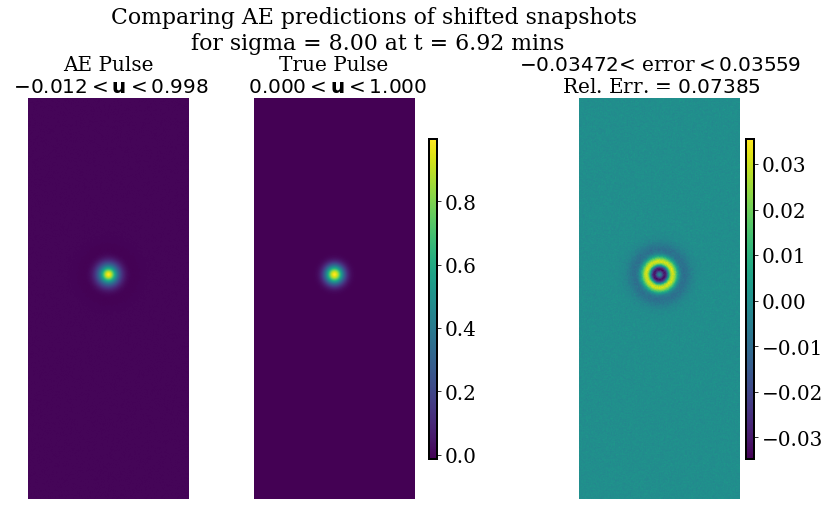

In [22]:
### Visualizing reconstruction of shifted snapshots using shift decoder
if new_test:
    fig = plt.figure(figsize=(14,8))
    p_inx = 0 
    ky = 'pulse'; 
    iplot = times_new[p_inx].size-5 
    
    print("comparing AE reconstruction at t = {0:.2f} mins".format(times_new[p_inx][iplot]/60))
    fig.tight_layout()
    fig.subplots_adjust(top=0.82)
    compare_soln(pred_shift_new[p_inx],shifted_snap_new[p_inx],iplot,times_new[p_inx],times_new[p_inx],Nx,Ny,ky)
    fig.suptitle("Comparing AE predictions of shifted snapshots \nfor %s = %.2f at t = %.2f mins"%(flag,test_param[p_inx], times_new[p_inx][iplot]/60),fontsize=22, y=0.98)


#     plt.savefig(fig_dir+'%s%s_c%.1f_sigma%.2f_SegmentedShiftAEshift_t%.3f_swish_NMSE.png'%(model,mnum,c_new[p_inx],sigma_new[p_inx],times_new[p_inx][iplot]/60),dpi=300,bbox_inches='tight')



comparing AE reconstruction at t = 6.92 mins


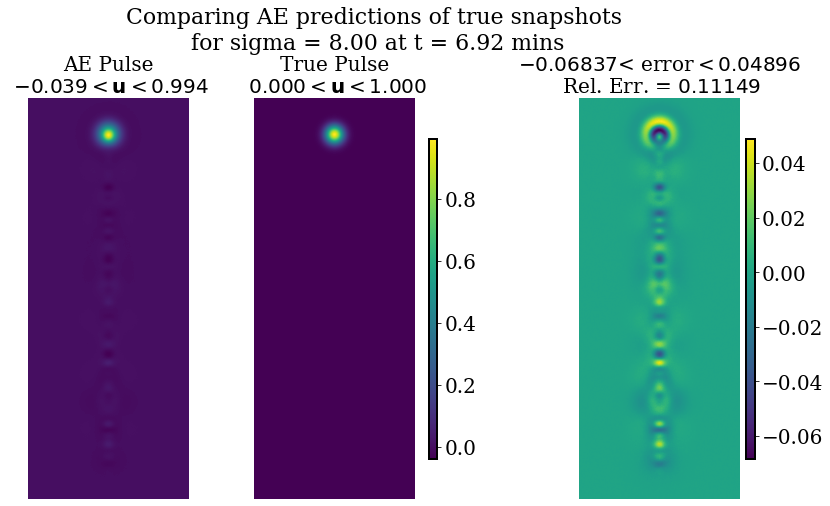

In [23]:
### Visualizing direct reconstruction using true decoder
if new_test:
    fig = plt.figure(figsize=(14,8))
    print("comparing AE reconstruction at t = {0:.2f} mins".format(times_new[p_inx][iplot]/60))
    fig.tight_layout()
    fig.subplots_adjust(top=0.82)
    compare_soln(pred_recon_new[p_inx],snap_new[p_inx],iplot,times_new[p_inx],times_new[p_inx],Nx,Ny,ky)
    fig.suptitle("Comparing AE predictions of true snapshots \nfor %s = %.2f at t = %.2f mins"%(flag,test_param[p_inx], times_new[p_inx][iplot]/60),fontsize=22, y=0.98)


#     plt.savefig(fig_dir+'%s%s_c%.1f_sigma%.2f_SegmentedShiftAErecon_t%.3f_swish_NMSE.png'%(model,mnum,c_new[p_inx],sigma_new[p_inx],times_new[p_inx][iplot]/60),dpi=300,bbox_inches='tight')



In [24]:
if new_test:
    ## Compute rel error for decoded prediction of shifted solutions
    rel_err_shift_new = {}
    rel_err_recon_new = {}
    key = 'pulse'
    shift_new_max = np.zeros(len(test_param))
    recon_new_max = np.zeros(len(test_param))
    for inx,val in enumerate(test_param):
        inx = test_param.index(val);
        true_new = shifted_snap_new[inx][key][:,:snap_end_new[inx]+1]
        true2_new = snap_new[inx][key][:,:snap_end_new[inx]+1]
        rel_err_shift_new[inx] = np.linalg.norm(pred_shift_new[inx][key][:,:]-true_new,axis=0)/np.linalg.norm(true_new,axis=0)
        rel_err_recon_new[inx] = np.linalg.norm(pred_recon_new[inx][key][:,:]-true2_new,axis=0)/np.linalg.norm(true2_new,axis=0)
        shift_new_max[inx] = np.amax(rel_err_shift_new[inx][:-5])
        recon_new_max[inx] = np.amax(rel_err_recon_new[inx][:-5])

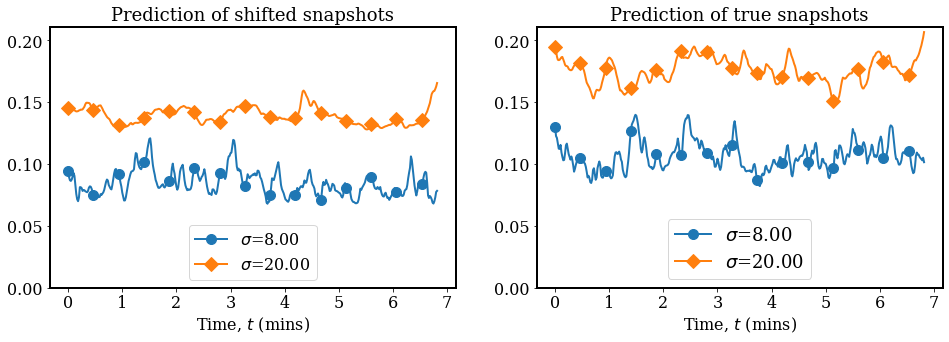

In [25]:
if new_test:
    ### Visualize relative errors for both decoders

    fig = plt.figure(figsize=(16,5))
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    
    mkrlist = ['o','D']
    
    y_new_max = np.maximum(shift_new_max.max(), recon_new_max.max())

    ax1 = plt.subplot(1,2,1)
    for inx,val in enumerate(test_param):
        inx = test_param.index(val);

        indx = times_new[inx][:snap_end_new[inx]+1]/60
        e_inx = indx.size -10
        ax1.plot(indx[:e_inx],rel_err_shift_new[inx][:e_inx],
                label='%s=%.2f'%(set_symbol(flag),val), marker=mkrlist[inx], 
                 markevery=28,markersize=10,)
    ax1.set_title('Prediction of shifted snapshots',fontsize=18)
    ax1.set_ylim(top=y_new_max, bottom=0.0)
    ax1.legend(ncol=1,loc='lower center'); ax1.set_xlabel('Time, $t$ (mins)')
    
        
        
    ax2 = plt.subplot(1,2,2)
    for inx,val in enumerate(test_param):
        inx = test_param.index(val);
        indx = times_new[inx][:snap_end_new[inx]+1]/60
        e_inx = indx.size -10
        ax2.plot(indx[:e_inx],rel_err_recon_new[inx][:e_inx],
                label='%s=%.2f'%(set_symbol(flag),val), marker=mkrlist[inx], 
                 markevery=28,markersize=10,)
    ax2.set_title('Prediction of true snapshots',fontsize=18)
    ax2.set_ylim(top=y_new_max, bottom=0.0)
    ax2.legend(ncol=1,loc='lower center',fontsize=18); ax2.set_xlabel('Time, $t$ (mins)')
    

#     plt.savefig(fig_dir+'%s%s_par%s_TestSegmentedShiftAErel_err_swish_NMSE.png'%(model,mnum,flag),dpi=300,bbox_inches='tight')


